In [1]:
import os
import sys
sys.path.append("../../../")
import configs.config as config

In [2]:
import dgl.nn as dglnn
from dgl import from_networkx
import dgl.function as fn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import src.models.MLP as mlp
import torch as th
import torch.nn.functional as F
import networkx as nx
import src.utils.EGScommon as EGScommon
import sklearn
from sklearn.model_selection import train_test_split

In [3]:
device = os.environ.get("DEVICE", config.DEVICE)

In [4]:
import os
import sys
sys.path.append("../../../")
import src.data.preprocessing.CICprep as CICprep

In [5]:
X_train = CICprep.X_train
X_test = CICprep.X_test
y_train = CICprep.y_train
y_test = CICprep.y_test 

In [6]:
G = nx.from_pandas_edgelist(X_train, ' Source IP', ' Destination IP', ['h', 'label'],create_using=nx.MultiGraph())
G = G.to_directed()
G = from_networkx(G, edge_attrs=['h', 'label'])

In [7]:
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [8]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [9]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [10]:
class_weights = EGScommon.EGScompute_class_weights(G)
class_weights = th.FloatTensor(class_weights).to(device)
criterion = th.nn.CrossEntropyLoss(weight=class_weights)

In [11]:
G = G.to(device)

In [12]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

accuracies = []
best_acc = 0
best_model_state = None
numclasses = len(y_train.value_counts())

model = mlp.Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2, numclasses).to(device)
opt = th.optim.Adam(model.parameters())

for epoch in range(1,200):
    pred = model(G, node_features,edge_features).to(device)
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 10 == 0:
      acc = EGScommon.compute_accuracy(pred[train_mask], edge_label[train_mask])
      accuracies.append(acc)
      print('Training acc:', EGScommon.compute_accuracy(pred[train_mask], edge_label[train_mask]))
      # Save the best model
      if acc > best_acc:
        best_acc = acc
        best_model_state = model.state_dict()
        print(f'New best accuracy: {best_acc:.4f}')

Training acc: 0.7985028624534607
New best accuracy: 0.7985
Training acc: 0.8866409063339233
New best accuracy: 0.8866
Training acc: 0.9190614223480225
New best accuracy: 0.9191
Training acc: 0.9575607180595398
New best accuracy: 0.9576
Training acc: 0.9577244520187378
New best accuracy: 0.9577
Training acc: 0.9671343564987183
New best accuracy: 0.9671
Training acc: 0.9702914953231812
New best accuracy: 0.9703
Training acc: 0.9718879461288452
New best accuracy: 0.9719
Training acc: 0.9727885127067566
New best accuracy: 0.9728
Training acc: 0.9726964235305786
Training acc: 0.9704091548919678
Training acc: 0.9745129346847534
New best accuracy: 0.9745
Training acc: 0.9714581370353699
Training acc: 0.9724559187889099
Training acc: 0.9765238165855408
New best accuracy: 0.9765
Training acc: 0.9771992564201355
New best accuracy: 0.9772
Training acc: 0.9777212142944336
New best accuracy: 0.9777
Training acc: 0.9785654544830322
New best accuracy: 0.9786
Training acc: 0.9775523543357849


In [13]:
print(f'Training completed. Best accuracy achieved: {best_acc:.4f}')

Training completed. Best accuracy achieved: 0.9786


In [14]:
# X_test is not defined - need to ensure it's loaded before this cell
# th is not imported - need to import torch as th
# nx is not imported - need to import networkx as nx
# from_networkx is not imported - need to import from dgl
G_test = nx.from_pandas_edgelist(X_test, " Source IP", " Destination IP", ['h','label'], create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test, edge_attrs=['h','label'])
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones((G_test.num_nodes(), G.ndata['h'].shape[2]))
# Add this line to reshape edge features
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [15]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [16]:
G_test = G_test.to(device)

In [17]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).to(device)
elapsed = timeit.default_timer() - start_time

In [18]:
print(f"Time taken: {elapsed:.2f} seconds")

Time taken: 0.10 seconds


In [19]:
test_pred = test_pred.argmax(1)

In [20]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

In [21]:
actual = ["Normal" if i == 0 else "Attack" for i in actual]
test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

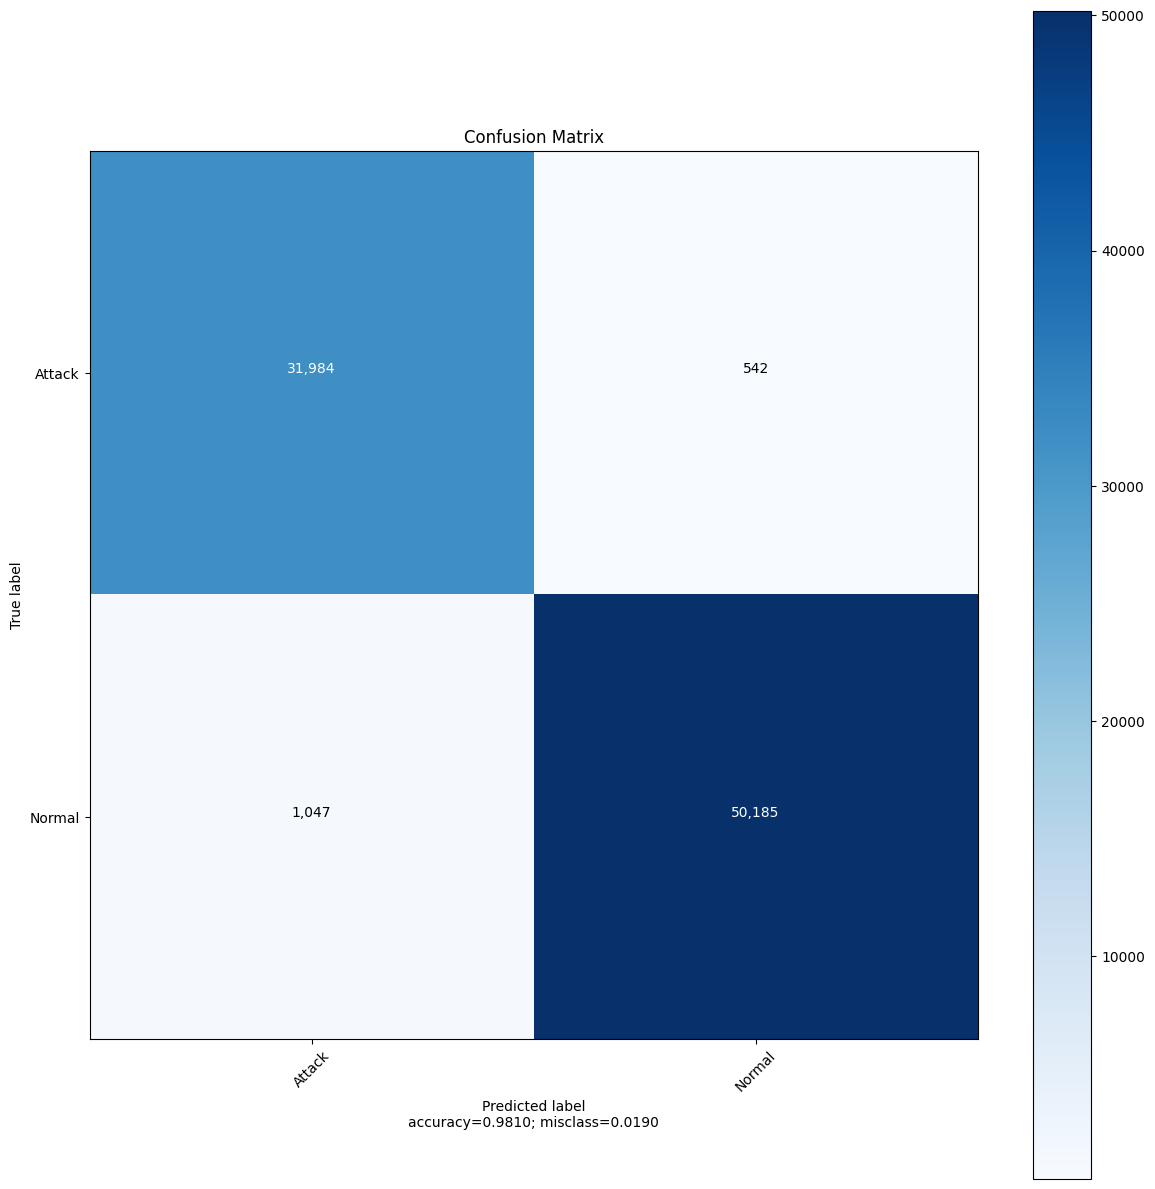

In [22]:
from sklearn.metrics import confusion_matrix

EGScommon.plot_confusion_matrix(confusion_matrix(actual, test_pred), 
                      normalize=False,
                      target_names = np.unique(actual),
                      title='Confusion Matrix')